In [1]:
import cv2
import numpy as np
import MySQLdb as mdb
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
#import keras as keras

In [3]:
siraCon = mdb.connect('atenea.twa.es', 'sira', 'sira65535', 'sira')
siraDB = siraCon.cursor()

In [4]:
labelTypes = ['good','fail','sucia','noche']
label_encoder = LabelEncoder()
label_encoder.fit(labelTypes)
print(label_encoder.transform(['good']))
print(label_encoder.inverse_transform([2]))
print(to_categorical(label_encoder.transform(['good']),4))

[1]
['noche']
[[ 0.  1.  0.  0.]]


# Prepare perspective transform

orgPoints is an area that I can easy determine and used to do the projection, it is not the full region of interest ROI area.

In [5]:
orgPoints=np.float32([[160,96],[245,96],[245,162],[160,162]])
dstPoints=np.float32([[12,22],[63,22],[63,73],[12,73]])
M = cv2.getPerspectiveTransform(orgPoints, dstPoints)

# Prepare training data

In [129]:
def loadImages(typeImage='',limit=-1,startDate='2017-09-01'):
    print("Loading images...")

    images = []
    labels = []
    dirregs = []
    if limit>0:
        limitStr="limit "+str(limit)
    else:
        limitStr = ""
    if(typeImage!=''):
        typeStr=" and campo11 = '"+ typeImage + "' "
    else:
        typeStr=""
    
    sqlstr = "select campo10, campo11, campo6, id from registroacciones where accion=9000 and campo10!='\"\"'"
    sqlstr += ' and timetx>\'' + startDate + "' "
    sqlstr += typeStr
    sqlstr += limitStr

    print(sqlstr)
    
    siraDB.execute(sqlstr)
    numrows = siraDB.rowcount
    
    
    print(numrows)
    
    for i in range(0,numrows):
        row = siraDB.fetchone()
        #print(row[0], "-->", row[1], row[2])
        image=cv2.imread(row[0])
        if image is None or image.shape!=(240, 320, 3):
            print("Error en imagen ", row)
            if image is not None:
                print("Shape = ",image.shape)
            continue
        #if we want to tranfsorm to HSV
        #image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
        warped = cv2.warpPerspective(image, M,(84, 84), flags=cv2.INTER_NEAREST)
        images.append(warped)
        #image time good=0, fail=1, dirty=2, night=4
        labels.append(row[1])
        dirregs.append(row[3])
    return numrows, images, labels, dirregs

In [130]:
numGoods, imagesGood,labelsGood, dirregsGood = loadImages('good',startDate='2017-09-01');
dummy, imagesFail,labelsFail, dirregsFail = loadImages('fail');
dummy, imagesSucia,labelsSucia, dirregsSucia = loadImages('sucia',numGoods);
dummy, imagesNoche,labelsNoche, dirregNoche = loadImages('noche');
images = imagesGood+imagesFail +imagesSucia + imagesNoche
labelsStrs = labelsGood+labelsFail+labelsSucia+labelsNoche
labels = to_categorical(label_encoder.transform(labelsStrs),4)
dirregs= dirregsGood + dirregsFail + dirregNoche +imagesSucia
print(np.array(images).shape)
print (labels.shape)

Loading images...
select campo10, campo11, campo6, id from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-09-01'  and campo11 = 'good' 
1933
Error en imagen  ('images/rec_1507982341.png', 'good', '12.1000003815', 17102378)
Error en imagen  ('images/rec_1507982778.png', 'good', '5.40000009537', 17102388)
Error en imagen  ('images/rec_1507983012.png', 'good', '8.10000038147', 17102393)
Error en imagen  ('images/rec_1507983055.png', 'good', '7.5', 17102394)
Error en imagen  ('images/rec_1507984201.png', 'good', '7.09999990463', 17102580)
Error en imagen  ('images/rec_1507984629.png', 'good', '6.40000009537', 17102587)
Error en imagen  ('images/rec_1507989276.png', 'good', '7.80000019073', 17102654)
Loading images...
select campo10, campo11, campo6, id from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-09-01'  and campo11 = 'fail' 
4881
Error en imagen  ('images/rec_1507979738.png', 'fail', '7.5', 17102294)
Error en imagen  ('images/rec_150797

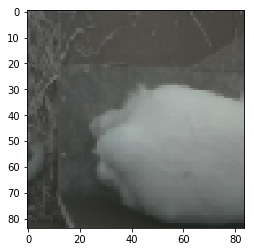

In [11]:
testImg=imagesGood[5].copy()
#cv2.fillPoly(testImg,[orgPoints.astype(int)],1)
plt.imshow(testImg)

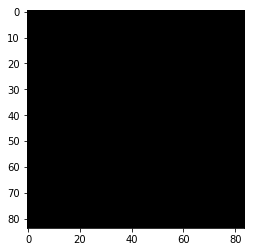

In [12]:
warped = cv2.warpPerspective(testImg, M,(84, 84), flags=cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))

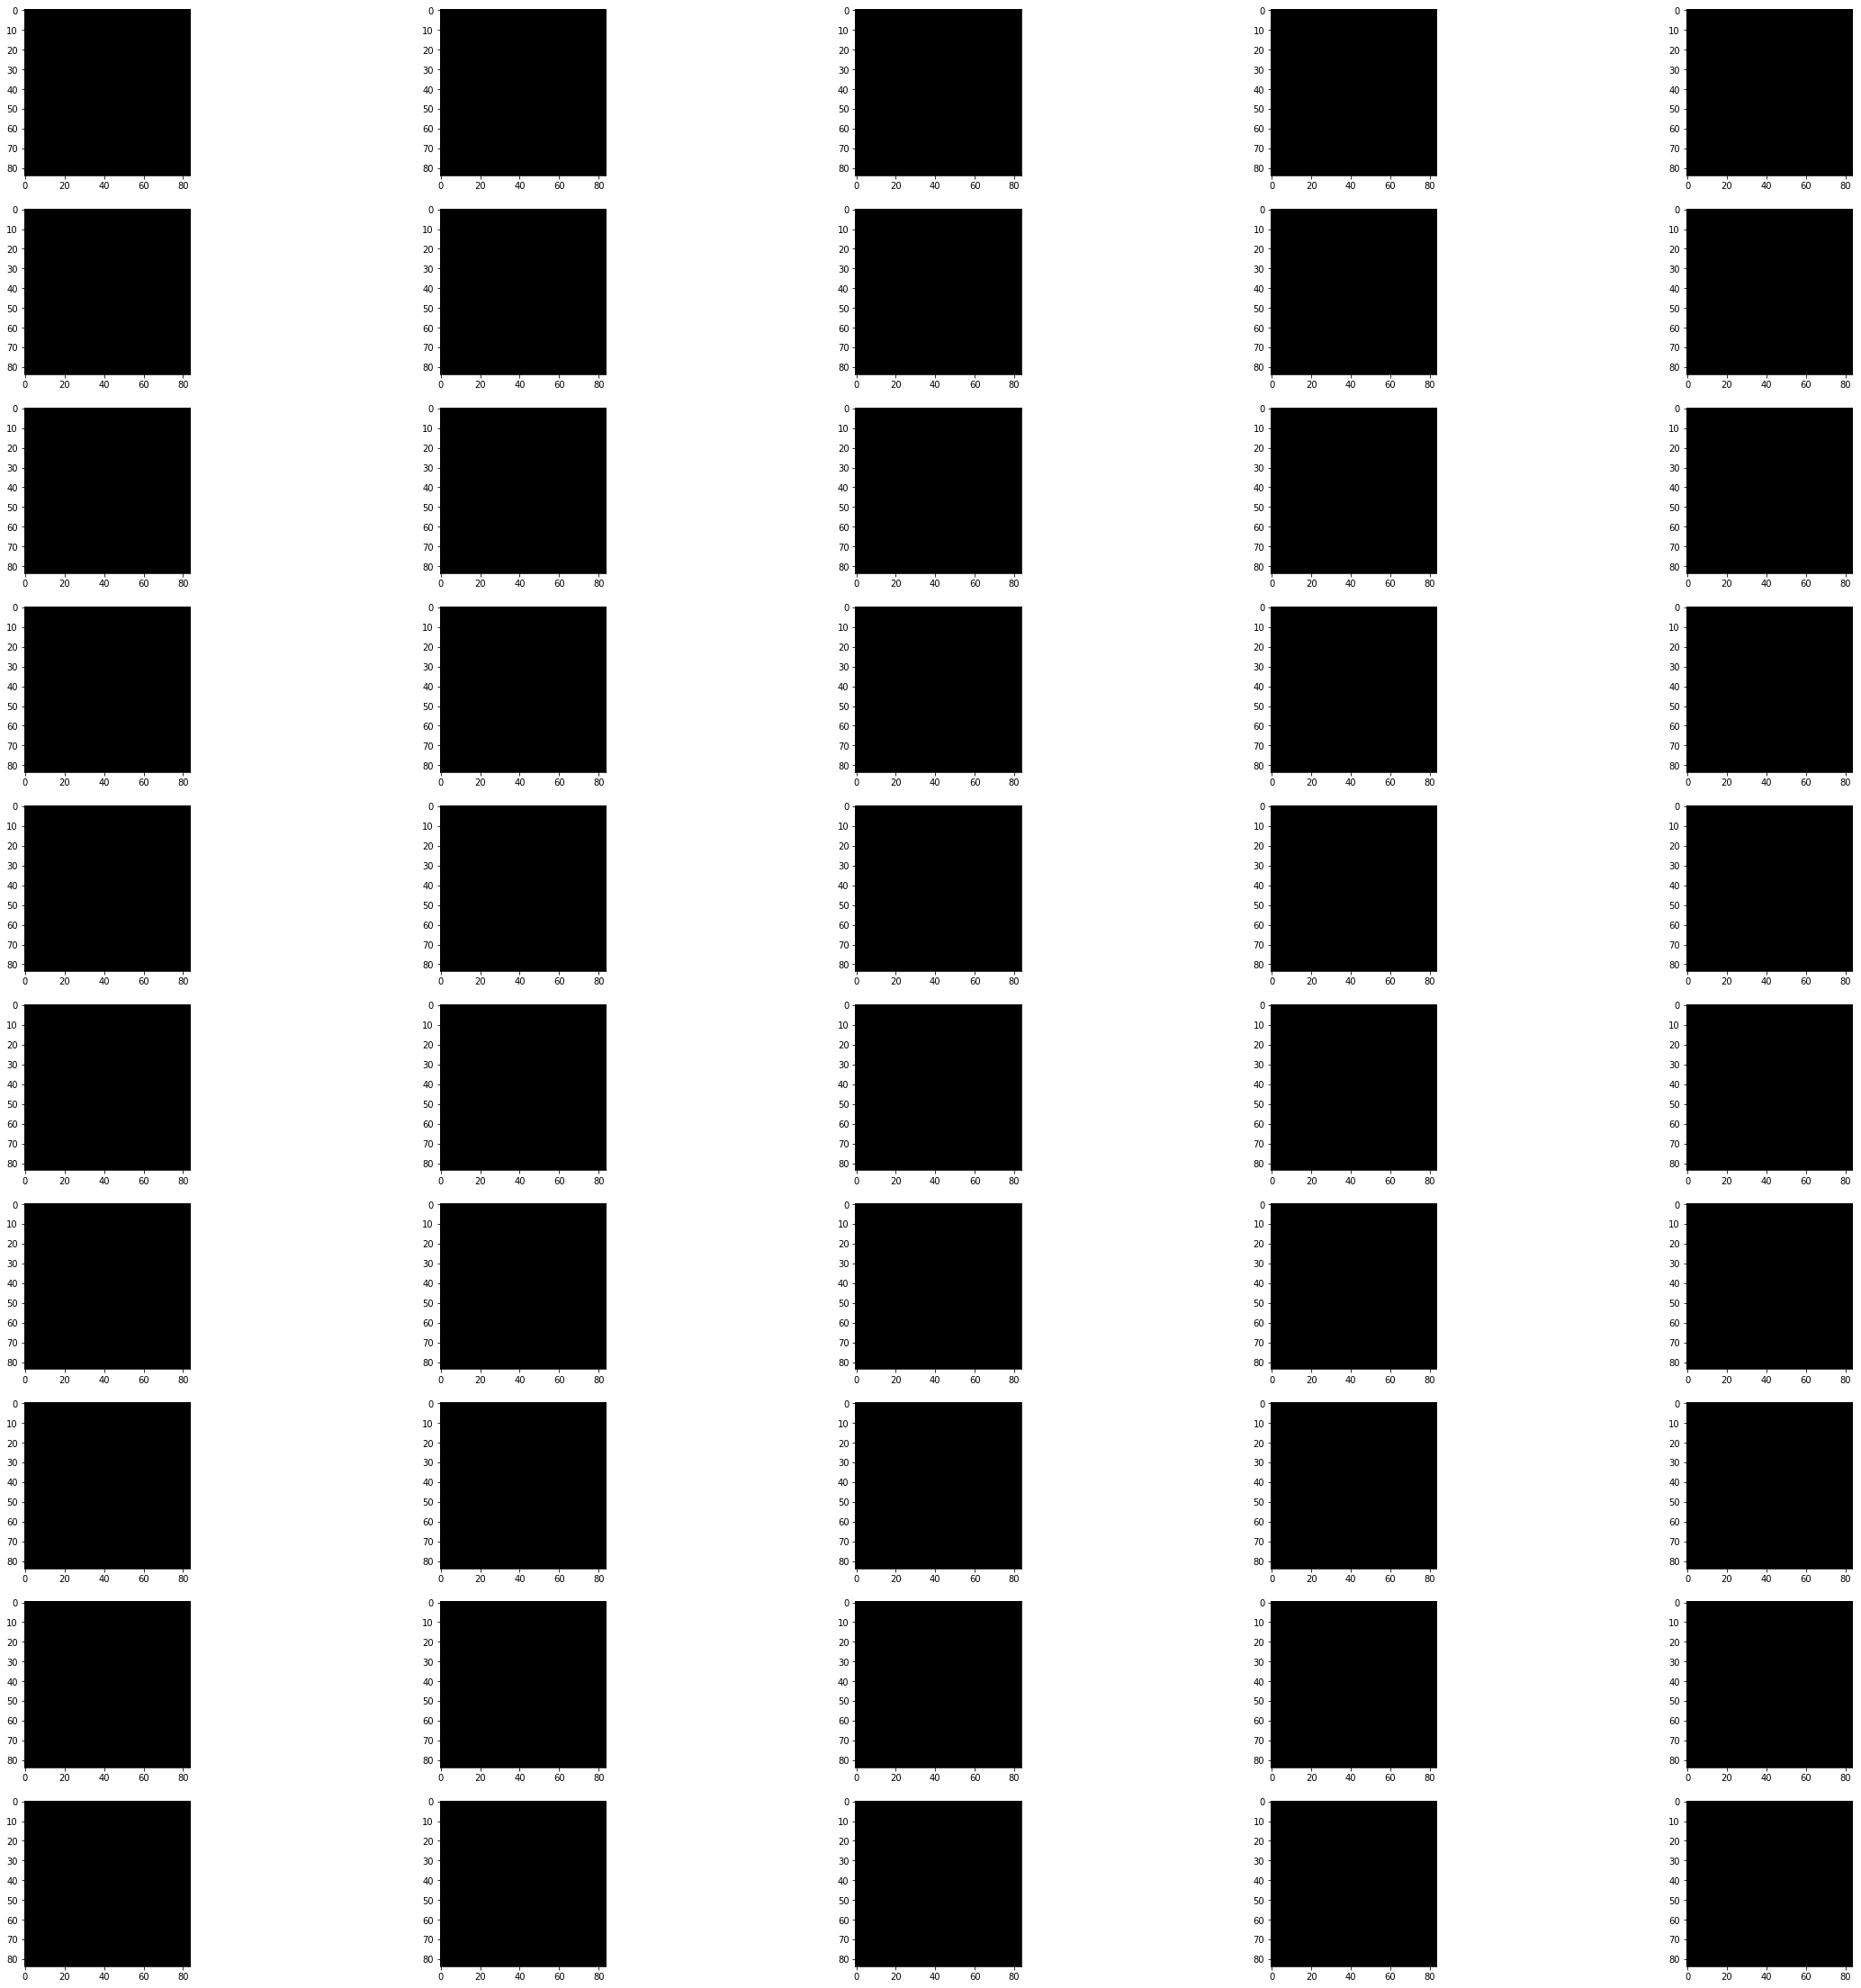

In [13]:
jj, axes= plt.subplots(10,5,figsize=(40,40))
for r in range(0,10):
    for c in range(0,5):
        testImg=images[5*r+c].copy()
        warped = cv2.warpPerspective(testImg, M,(84, 84), flags=cv2.INTER_NEAREST)
        #plt.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
        axes[r][c].imshow(warped)
    
#axes[0].set_title("Original")
#axes[1].imshow(dst)
#axes[1].set_title("Undistorted")
pass #avoid ugly output about title

In [57]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPool2D, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import random



def modelDef(dropout=0.4):
    
    print("Creating NVidea model...")
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(84, 84, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(36,(5,5), strides=(2,2), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(48,(5,5), strides=(2,2), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(50))
    model.add(Dropout(dropout))
    model.add(Dense(10))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam")
    #model.compile(loss='mse', optimizer=Adam()
    return model


In [59]:
def trainDriver(model, X_train,y_train, epochs):
    print("Training the model...")
    model.fit(X_train,y_train,validation_split=0.20, shuffle=True,epochs=epochs)

model = modelDef(dropout=.4)
trainDriver(model, np.array(images),np.array(labels),16)


Creating NVidea model...
Training the model...
Train on 6961 samples, validate on 1741 samples
Epoch 1/16
6961/6961 [==============================] - 3s - loss: 0.6854 - val_loss: 1.7633
Epoch 2/16
6961/6961 [==============================] - 3s - loss: 0.6056 - val_loss: 2.1193
Epoch 3/16
6961/6961 [==============================] - 3s - loss: 0.5520 - val_loss: 1.7498
Epoch 4/16
6961/6961 [==============================] - 3s - loss: 0.5186 - val_loss: 1.6381
Epoch 5/16
6961/6961 [==============================] - 3s - loss: 0.4906 - val_loss: 1.7447
Epoch 6/16
6961/6961 [==============================] - 3s - loss: 0.4838 - val_loss: 1.7248
Epoch 7/16
6961/6961 [==============================] - 3s - loss: 0.4757 - val_loss: 1.5852
Epoch 8/16
6961/6961 [==============================] - 3s - loss: 0.4608 - val_loss: 1.5927
Epoch 9/16
6961/6961 [==============================] - 3s - loss: 0.4536 - val_loss: 1.5840
Epoch 10/16
6961/6961 [==============================] - 3s - loss: 

In [47]:

numGoods, imagesGood_test,labelsGood_test = loadImages(typeImage='good',limit=100,startDate='2017-10-10')
numGoods=100
dummy, imagesFail_test,labelsFail_test = loadImages('fail',numGoods,startDate='2017-10-10')
dummy, imagesSucia_test,labelsSucia_test = loadImages('sucia',numGoods,startDate='2017-10-10')
dummy, imagesNoche_test,labelsNoche_test = loadImages('noche',numGoods,startDate='2017-10-10)                                                      ');
images_test = imagesGood_test+imagesFail_test +imagesSucia_test + imagesNoche_test
labelsStrs_test = labelsGood_test+labelsFail_test+labelsSucia_test+labelsNoche_test
labels_test = to_categorical(label_encoder.transform(labelsStrs_test),4)


Loading images...
select campo10, campo11, campo6 from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-10-10'  and campo11 = 'good' limit 100
100
Loading images...
select campo10, campo11, campo6 from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-10-10'  and campo11 = 'fail' limit 100
100
Loading images...
select campo10, campo11, campo6 from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-10-10'  and campo11 = 'sucia' limit 100
33
Loading images...
select campo10, campo11, campo6 from registroacciones where accion=9000 and campo10!='""' and timetx>'2017-10-10)                                                      '  and campo11 = 'noche' limit 100
100


In [60]:
result = model.predict(np.array(images_test))
#,np.array(labels),2)np.array(windowed), batch_size=1)

In [61]:
result.argmax(axis=1)

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

# Save results to DB

In [132]:
result = model.predict(np.array(images))
print(result.shape)


(9916, 4)


In [142]:

for i in range (0,result.shape[0]):

    sqlstr = "update registroacciones set campo12='"+label_encoder.inverse_transform(result[i].argmax()) +"' where id="+str(dirregs[i]) 
    siraDB.execute(sqlstr)
siraCon.commit()


In [113]:
errors= result.argmax(axis=1)!=labels_test.argmax(axis=1)
eImages=np.array(images_test)[errors]
eLables=np.array(labelsStrs_test)[errors]
eResult=result[errors]

ValueError: y contains new labels: [37]

In [109]:
eResult.shape[0]%5
r=1
axes[math.floor(r/5)][r%5]
print ("Lab= ",eLables[r], " res: " ,label_encoder.inverse_transform(eResult[r].argmax()))

Lab=  good  res:  fail


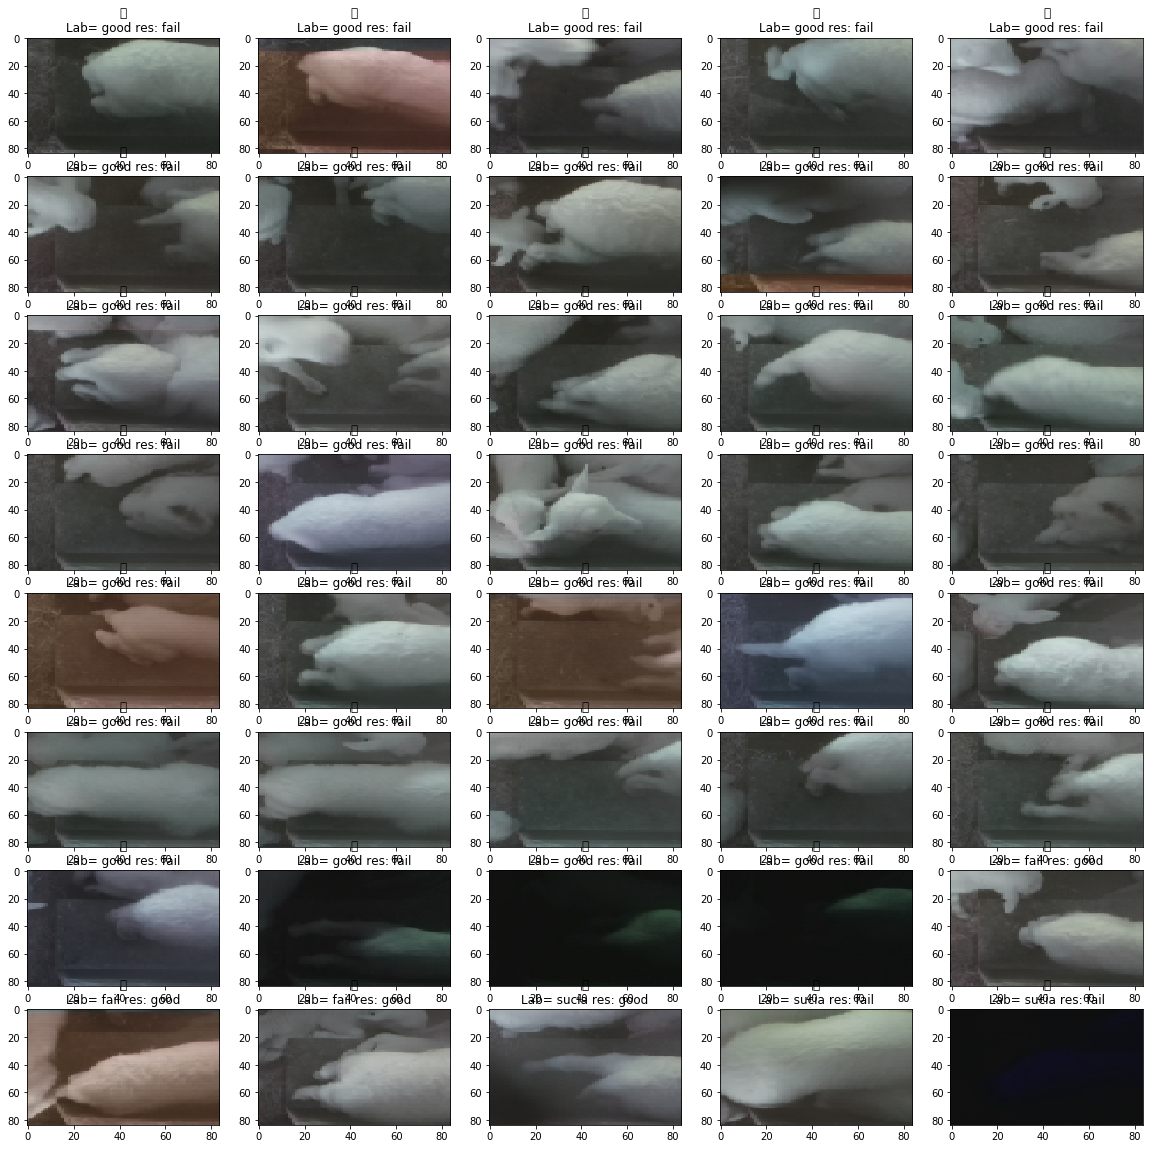

In [144]:
elems=eResult.shape[0]
elems=40
jj, axes= plt.subplots(math.ceil(elems/5),5,figsize=(20,20))
for r in range(0,elems):
    axes[math.floor(r/5)][r%5].imshow(eImages[r],aspect='auto')
    axes[math.floor(r/5)][r%5].set_title("\r\nLab= "+eLables[r]+ " res: " +label_encoder.inverse_transform(eResult[r].argmax()))
